allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


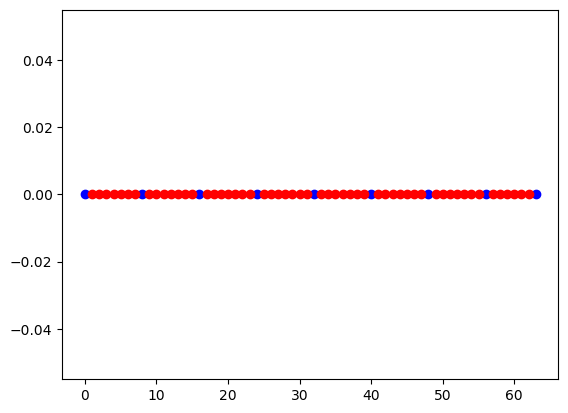

In [47]:
import numpy as np
import scipy.interpolate
import scipy
import matplotlib.pyplot as plt

K = 64 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')

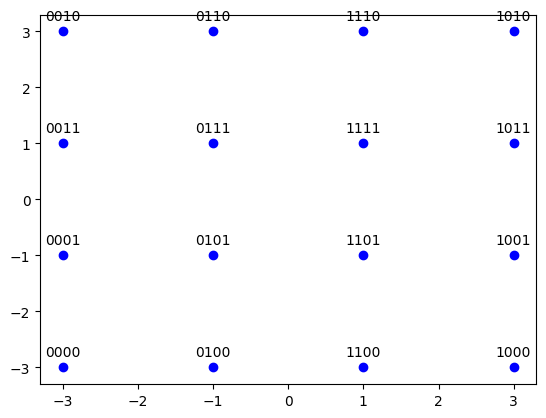

In [48]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

In [49]:
demapping_table = {v : k for k, v in mapping_table.items()}

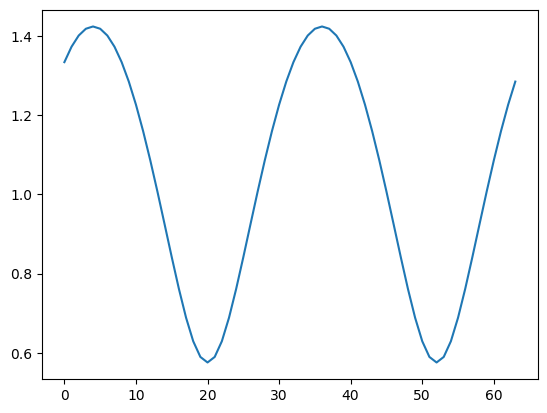

In [50]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))

SNRdb = 25  # signal to noise-ratio in dB at the receiver 

In [51]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))

Bits count:  220
First 20 bits:  [0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0]
Mean of bits (should be around 0.5):  0.4318181818181818


In [52]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])

First 5 bit groups
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 1]
 [1 0 1 0]]


In [53]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 1]
 [1 0 1 0]]
[-3.+3.j  3.+3.j -1.-1.j  3.+1.j  3.+3.j]


In [54]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))

Number of OFDM carriers in frequency domain:  64


In [55]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  64


In [56]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  80


RX Signal power: 0.2313. Noise power: 0.0007


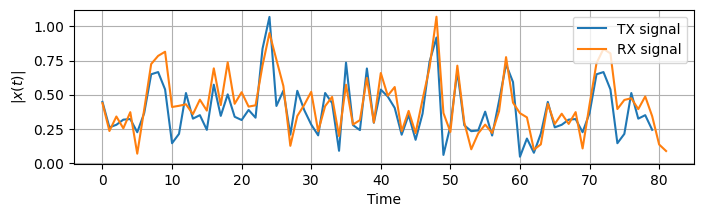

In [57]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [58]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [59]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

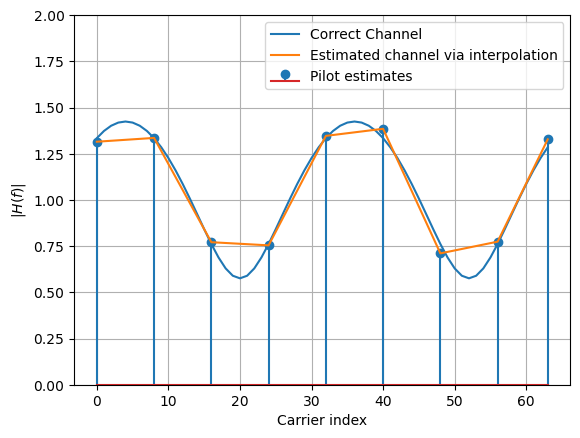

In [60]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)

In [61]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

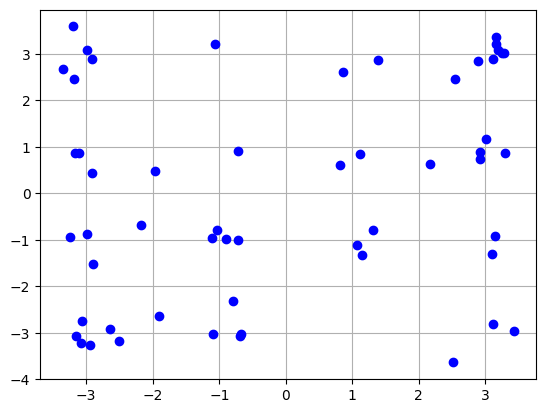

In [62]:
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');
plt.grid(True)

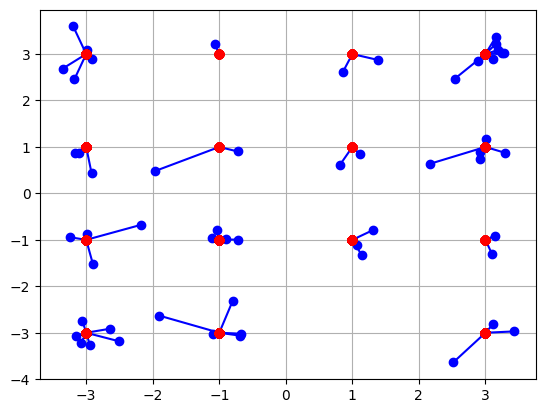

In [63]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
    plt.grid(True)

In [64]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

In [65]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.00909090909090909
